In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
from esem import gp_model
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

2024-02-26 17:32:49.982055: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 17:32:49.986019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 17:32:49.987706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 17:32:50.007215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-26 17:32:52.214546: W tensorflow/comp

### Prepare data

In [2]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG"]

In [4]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_pr = create_predictdand_data(train_files)['pr90'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
pr_truth = Y_test["pr90"].mean('member')

In [5]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_pr = y_train_pr[~nan_train_mask]
assert len(X_train) == len(y_train_pr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
pr_truth = pr_truth[~nan_test_mask]

In [6]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [7]:
# Standardize predictand fields
train_pr_mean, train_pr_std = y_train_pr.mean(), y_train_pr.std()
y_train_pr = (y_train_pr - train_pr_mean) / train_pr_std

# Scale pr
pr_truth *= 86400

### Prepare model

In [8]:
import gpflow
from gpflow.utilities import to_default_float
from gpflow.optimizers import Scipy
from gpflow.mean_functions import Constant
from gpflow.kernels import Matern52
from gpflow.utilities import print_summary

In [9]:
def create_feature_extractor(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='linear'),
        tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float64))
    ])
    return model


In [10]:
class DeepKernel(gpflow.kernels.Kernel):
    def __init__(self, feature_extractor, base_kernel, input_dim):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.base_kernel = base_kernel
        self.input_dim = input_dim

    def K(self, X, X2=None):
        # Transform X and X2 using the neural network
        X_transformed = self.feature_extractor(X)
        X2_transformed = self.feature_extractor(X2) if X2 is not None else X2
        # Compute the kernel using the transformed inputs
        return self.base_kernel(X_transformed, X2_transformed)

    def K_diag(self, X):
        X_transformed = self.feature_extractor(X)
        return self.base_kernel.K_diag(X_transformed)


In [11]:
# Define the neural network feature extractor
input_dim = X_train.shape[1]  # Number of features in X
output_dim = 24
feature_extractor = create_feature_extractor(input_dim, output_dim)

# Freeze the neural network layers to make them non-trainable in GPflow's optimization process
for layer in feature_extractor.layers:
    layer.trainable = True

# Define the base kernel and the deep kernel
kernel_CO2 = Matern52(active_dims=[0, 1], variance=1.0, lengthscales=2 * [1.])
kernel_CH4 = Matern52(active_dims=[2, 3], variance=1.0, lengthscales=2 * [1.])
kernel_BC = Matern52(active_dims=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], variance=1.0, lengthscales=10 * [1.])
kernel_SO2 = Matern52(active_dims=[14, 15, 16, 17, 18, 19, 20, 21, 22, 23], variance=1.0, lengthscales=10 * [1.])

kernel_matern12 = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

base_kernel = kernel_matern12
deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

# Mean Function
mean_function = Constant()

# Create the GP model
model = gpflow.models.GPR(data=(X_train.astype(float), y_train_pr.astype(float)), kernel=deep_kernel, mean_function=mean_function)

# Compile the TensorFlow model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def optimization_step():
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        loss = -model.log_marginal_likelihood()
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

2024-02-26 17:33:25.335199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38374 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0


In [12]:
tolerance = 1e-6  # Define tolerance
patience = 10  # Define patience

# Initialize variables for early stopping mechanism
best_loss = float('inf')
patience_counter = 0
max_iterations = 5000

# Training loop
for iteration in range(max_iterations):  # Number of optimization steps
    loss = optimization_step()

    # Early stopping logic
    if best_loss - loss < tolerance:
        patience_counter += 1
    else:
        patience_counter = 0
        best_loss = loss

    if patience_counter >= patience:
        print(f"Stopping training after {iteration + 1} iterations due to convergence.")
        break

2024-02-26 17:33:34.266641: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0xe785270
2024-02-26 17:33:34.378537: I external/local_xla/xla/service/service.cc:168] XLA service 0x150da05027e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-26 17:33:34.378568: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-02-26 17:33:34.385413: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-26 17:33:34.420324: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1708994014.547364   11465 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Stopping training after 102 iterations due to convergence.


### Predict on testing set

In [13]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_pr_std

In [14]:
# put output back into xarray format for calculating RMSE/plotting
posterior_pr = np.reshape(posterior_mean, [86, 96, 144])
posterior_pr_std = np.reshape(posterior_std, [86, 96, 144])

posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
posterior_pr_std_data = xr.DataArray(posterior_pr_std, dims=pr_truth.dims, coords=pr_truth.coords)

In [15]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(pr_truth[35], posterior_pr_data[35])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[85], posterior_pr_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[30:41], posterior_pr_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[75:], posterior_pr_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[35:], posterior_pr_data[35:]).mean()}")

RMSE at 2050: 1.496263440487797
RMSE at 2100: 2.455291159338798
RMSE 2045-2055: 1.6460619587655352
RMSE 2090-2100: 1.9931437691297347
RMSE 2050-2100: 1.8318096242095212


[Text(0.5, 1.0, 'Difference')]

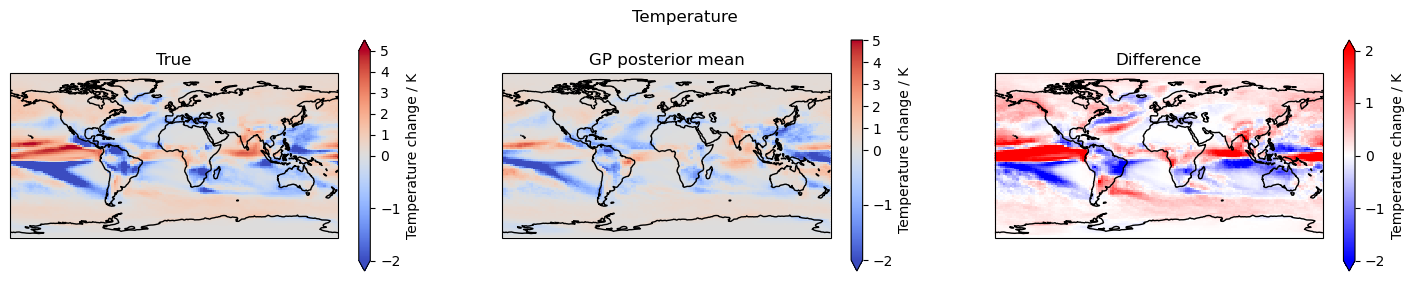

In [16]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_pr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr_truth - posterior_pr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [17]:
def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

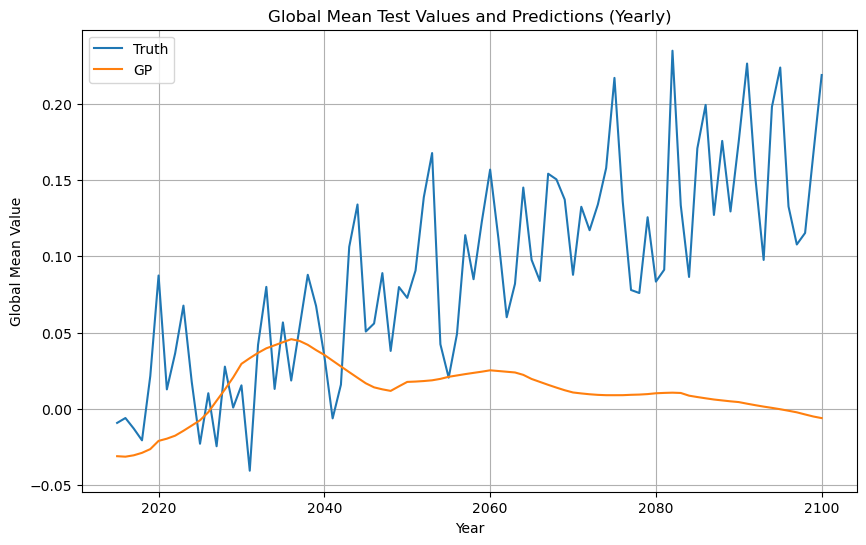

In [18]:
# t = xr.open_dataarray('climatebench-gp-posterior-mean-pr-test-2019-2100.nc')
plt.figure(figsize=(10, 6))
global_mean(pr_truth).plot(label="Truth")
global_mean(posterior_pr_data).plot(label='GP')
# global_mean(t).plot(label='from repo')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

## Hyperparams Tuning

In [19]:
from ray import tune, train
from ray.tune.search.hyperopt import HyperOptSearch
from gpflow.kernels import Matern12, Matern32, Matern52, SquaredExponential, RationalQuadratic, Cosine, Periodic, Polynomial, ArcCosine, Exponential
import keras
import math
from gpflow.mean_functions import Constant
from xskillscore import rmse
from ray.tune import CLIReporter

In [20]:
def get_rmse(truth, pred):
    return np.sqrt(((truth-pred)**2))

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).sum(['lat', 'lon'])

weights = np.cos(np.deg2rad(pr_truth.lat)).expand_dims(lon=144).assign_coords(lon=pr_truth.lon)
    
def TNRMSE(truth, pred, Yearslice=slice(2080, None)):
    # R2E Score
    R2E = rmse(
        global_mean(truth.sel(time=Yearslice)), 
        global_mean(pred.sel(time=Yearslice))
    ).data/np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    # NRMSE score
    NRMSE = rmse(
        truth.sel(time=Yearslice).mean('time'), 
        pred.sel(time=Yearslice).mean('time'), weights=weights
    ).data/ np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    total = (NRMSE + 5*R2E).T.round(3)
    return total

In [21]:
def make_feature_extractor(dim_max, activation, input_dim, output_dim, dropout_prob, bnorm=True, dropout=True):
    model = tf.keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_dim,)))
    
    dimensions = [dim_max // (2 ** i) for i in range(int(math.log(dim_max, 2)) + 1) if dim_max // (2 ** i) > input_dim]

    for dim in dimensions[::-1]:
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    for dim in dimensions:
        if dim <= output_dim:
            break
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    model.add(keras.layers.Dense(output_dim, activation='linear'))
    model.add(keras.layers.Lambda(lambda x: tf.cast(x, tf.float64)))
        
    return model

In [22]:
def basekernel(kernel_types, active_dim_multiplier, variance=1.0, lengthscales=1.0):
    kernels = {
        'Matern12': Matern12, 'Matern32': Matern32, 'Matern52': Matern52, 'SquaredExponential': SquaredExponential, 'RationalQuadratic': RationalQuadratic, 'Cosine':Cosine, 'Periodic': Periodic,
        'Polynomial': Polynomial, 'ArcCosine': ArcCosine, 'Exponential': Exponential
    }
    dims = [x for x in range(12*active_dim_multiplier)]
    def CO2(kernel):
        active_dims = dims[0:active_dim_multiplier*1]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k

    def CH4(kernel):
        active_dims = dims[1*active_dim_multiplier:active_dim_multiplier*2]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k
        
    def BC(kernel):
        active_dims = dims[2*active_dim_multiplier:active_dim_multiplier*2 + 5*active_dim_multiplier]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k

    def SO2(kernel):
        active_dims = dims[active_dim_multiplier*2 + 5*active_dim_multiplier:]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k
    
    kernel = CO2(kernels[kernel_types[0]]) + CH4(kernels[kernel_types[1]]) + BC(kernels[kernel_types[2]]) + SO2(kernels[kernel_types[3]])

    return kernel

In [45]:
def objective(config, return_pred=False):  # ①
    input_dim = X_train.shape[1]  # Number of features in X
    
    output_dim = config["output_dim"]
    # Feature extractor for deep kernel
    feature_extractor = make_feature_extractor(
        config["dim_max"], config["activation"], input_dim, config["output_dim"], config["dropout_prob"], bnorm=config["bnorm"], dropout=config["dropout"]
    )
    
    # Freeze the neural network layers to make them non-trainable in GPflow's optimization process
    for layer in feature_extractor.layers:
        layer.trainable = True
    
    # Define kernel
    base_kernel = basekernel(
        config["kernel_types"], config["active_dim_multiplier"]
    )
    deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

    mean_function = Constant() # Define Mean function

    optimizer  = tf.keras.optimizers.Adam(learning_rate=config["optimizer_lr"])# Define opt

    model = gpflow.models.GPR(data=(X_train.astype(float), y_train_pr.astype(float)), kernel=deep_kernel, mean_function=mean_function)
    

    # custom optimizer
    @tf.function
    def optimization_step():
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            loss = -model.log_marginal_likelihood()
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss


    # Training
    tolerance, patience = 1e-6, 10  # Define tolerance and patience

    # Initialize variables for early stopping mechanism
    best_loss, patience_counter, max_iterations = float('inf'), 0, 10000
    
    # Training loop
    for iteration in range(max_iterations):  # Number of optimization steps
        loss = optimization_step()
    
        # Early stopping logic
        if best_loss - loss < tolerance:
            patience_counter += 1
        else:
            patience_counter = 0
            best_loss = loss
    
        if patience_counter >= patience:
            print(f"Stopping training after {iteration + 1} iterations due to convergence.")
            break

    # Eval
    standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
    posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean
    posterior_std = np.sqrt(standard_posterior_var) * train_pr_std

    # put output back into xarray format for calculating RMSE/plotting
    posterior_pr = np.reshape(posterior_mean, [86, 96, 144])
    posterior_pr_std = np.reshape(posterior_std, [86, 96, 144])
    
    posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
    posterior_pr_std_data = xr.DataArray(posterior_pr_std, dims=pr_truth.dims, coords=pr_truth.coords)

    total_NRMSE = TNRMSE(pr_truth, posterior_pr_data)

    if return_pred:
        return posterior_pr_data, posterior_pr_std_data


    return {'nrmse':total_NRMSE}

In [24]:
def run_tuner(search_space, num_samples=50):
    algo = HyperOptSearch()
    
    tuner = tune.Tuner(  # ③
        tune.with_resources(
            objective,
            resources={"cpu": 1, "gpu": 1}
        ),
        tune_config=tune.TuneConfig(
            metric="nrmse",
            mode="min",
            num_samples=num_samples,
            search_alg=algo,
        ),
        param_space=search_space,
    )

    results = tuner.fit()
    return results

In [25]:
search_space_2 = {
        "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
        "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 512]), 
        "output_dim": tune.choice([36, 48, 60, 72, 84]), "optimizer_lr": tune.choice([0.01, 0.001, 0.0001])
    }  # ②

search_space_1 = {
    "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
    "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52'], 4*['SquaredExponential']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 64]), 
    "output_dim": tune.choice([12, 24, 36, 48, 60]), "optimizer_lr": tune.choice([0.01, 0.001])
} 

run_tuner(search_space_1)

(raylet) Warning: The actor ImplicitFunc is very large (71 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(pid=16228) 2024-02-26 17:36:39.266107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=16228) 2024-02-26 17:36:39.266219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=16228) 2024-02-26 17:36:39.271704: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=16228) 2024-02-26 17:36:40.700715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(objective pid=16228) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e8cd894160> and will run it as-is.
(objective pid=16228) Please repo

(objective pid=16228) Stopping training after 176 iterations due to convergence.


2024-02-26 17:37:09,707	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=16228) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e8cd894430> and will run it as-is.
(objective pid=16228) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=16228) Cause: Unknown node type <gast.gast.Import object at 0x14e8cd9843a0>
(objective pid=16228) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=16228) Stopping training after 119 iterations due to convergence.


2024-02-26 17:37:20,802	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=16228) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e860355160> and will run it as-is.
(objective pid=16228) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=16228) Cause: Unknown node type <gast.gast.Import object at 0x14e8cd815b80>
(objective pid=16228) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:37:31,114	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=16228) Stopping training after 191 iterations due to convergence.


(objective pid=16228) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e8087cf5e0> and will run it as-is.
(objective pid=16228) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=16228) Cause: Unknown node type <gast.gast.Import object at 0x14e87406aaf0>
(objective pid=16228) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:37:40,846	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=16228) Stopping training after 76 iterations due to convergence.


(objective pid=16228) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e8cd93faf0> and will run it as-is.
(objective pid=16228) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=16228) Cause: Unknown node type <gast.gast.Import object at 0x14e801a0bc10>
(objective pid=16228) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:37:52,037	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=16228) Stopping training after 125 iterations due to convergence.


(objective pid=16228) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e801899280> and will run it as-is.
(objective pid=16228) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=16228) Cause: Unknown node type <gast.gast.Import object at 0x14e8011ee9a0>
(objective pid=16228) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=16228) Stopping training after 148 iterations due to convergence.


2024-02-26 17:38:03,654	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=16228) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e8228b2b80> and will run it as-is.
(objective pid=16228) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=16228) Cause: Unknown node type <gast.gast.Import object at 0x14e8015b1040>
(objective pid=16228) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:38:17,587	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=16228) Stopping training after 498 iterations due to convergence.


(objective pid=16228) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e80137bee0> and will run it as-is.
(objective pid=16228) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=16228) Cause: Unknown node type <gast.gast.Import object at 0x14e801598dc0>
(objective pid=16228) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:38:28,408	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=16228) Stopping training after 288 iterations due to convergence.


(objective pid=16228) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e8228b2430> and will run it as-is.
(objective pid=16228) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=16228) Cause: Unknown node type <gast.gast.Import object at 0x14e8009f9220>
(objective pid=16228) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=16228) 2024-02-26 17:38:43.105440: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=16228) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=16228) Current allocation summary follows.
(obje

(objective pid=17032) Stopping training after 408 iterations due to convergence.


2024-02-26 17:39:16,050	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=17032) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1528a500a040> and will run it as-is.
(objective pid=17032) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17032) Cause: Unknown node type <gast.gast.Import object at 0x1527cc85d760>
(objective pid=17032) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:39:28,125	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=17032) Stopping training after 84 iterations due to convergence.


(objective pid=17032) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1528203e5280> and will run it as-is.
(objective pid=17032) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17032) Cause: Unknown node type <gast.gast.Import object at 0x1527cc2d17c0>
(objective pid=17032) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=17032) Stopping training after 78 iterations due to convergence.


2024-02-26 17:39:40,158	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=17032) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1528200c1280> and will run it as-is.
(objective pid=17032) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17032) Cause: Unknown node type <gast.gast.Import object at 0x15288d5522e0>
(objective pid=17032) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:39:50,649	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=17032) Stopping training after 133 iterations due to convergence.


(objective pid=17032) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1527cc42e670> and will run it as-is.
(objective pid=17032) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17032) Cause: Unknown node type <gast.gast.Import object at 0x1527c50cee50>
(objective pid=17032) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=17032) Stopping training after 531 iterations due to convergence.


2024-02-26 17:40:08,406	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=17032) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1527cc4af9d0> and will run it as-is.
(objective pid=17032) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17032) Cause: Unknown node type <gast.gast.Import object at 0x1527c513a040>
(objective pid=17032) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=17032) Stopping training after 274 iterations due to convergence.


2024-02-26 17:40:18,920	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=17032) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1527c4adf5e0> and will run it as-is.
(objective pid=17032) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17032) Cause: Unknown node type <gast.gast.Import object at 0x1527c50ce8e0>
(objective pid=17032) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:40:27,531	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=17032) Stopping training after 154 iterations due to convergence.


(objective pid=17032) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1527c4438d30> and will run it as-is.
(objective pid=17032) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17032) Cause: Unknown node type <gast.gast.Import object at 0x1527c4d16eb0>
(objective pid=17032) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=17032) 2024-02-26 17:40:41.742313: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=17032) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=17032) Current allocation summary follows.
(objective pid=17032)

(objective pid=17864) Stopping training after 182 iterations due to convergence.


2024-02-26 17:41:18,020	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=17864) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146cc07771f0> and will run it as-is.
(objective pid=17864) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17864) Cause: Unknown node type <gast.gast.Import object at 0x146cb13d8ac0>
(objective pid=17864) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:41:26,624	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=17864) Stopping training after 171 iterations due to convergence.


(objective pid=17864) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146cc07771f0> and will run it as-is.
(objective pid=17864) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17864) Cause: Unknown node type <gast.gast.Import object at 0x146d1a33d910>
(objective pid=17864) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:41:34,351	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=17864) Stopping training after 107 iterations due to convergence.


(objective pid=17864) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146cc07770d0> and will run it as-is.
(objective pid=17864) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17864) Cause: Unknown node type <gast.gast.Import object at 0x146c5448c1c0>
(objective pid=17864) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=17864) Stopping training after 428 iterations due to convergence.


2024-02-26 17:41:49,719	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=17864) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146cc07770d0> and will run it as-is.
(objective pid=17864) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17864) Cause: Unknown node type <gast.gast.Import object at 0x146c4dd8e6a0>
(objective pid=17864) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:41:57,704	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=17864) Stopping training after 16 iterations due to convergence.


(objective pid=17864) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146cc0777310> and will run it as-is.
(objective pid=17864) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17864) Cause: Unknown node type <gast.gast.Import object at 0x146c54461e80>
(objective pid=17864) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=17864) Stopping training after 957 iterations due to convergence.


2024-02-26 17:42:13,515	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=17864) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146c4dda04c0> and will run it as-is.
(objective pid=17864) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17864) Cause: Unknown node type <gast.gast.Import object at 0x146c4d3c3730>
(objective pid=17864) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=17864) Stopping training after 1154 iterations due to convergence.


2024-02-26 17:42:31,057	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=17864) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146c4d9e08b0> and will run it as-is.
(objective pid=17864) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=17864) Cause: Unknown node type <gast.gast.Import object at 0x146c4dc5c3a0>
(objective pid=17864) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=17864) 2024-02-26 17:42:45.138140: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(ob

(objective pid=18570) Stopping training after 990 iterations due to convergence.


2024-02-26 17:43:24,366	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=18570) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1470718efa60> and will run it as-is.
(objective pid=18570) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=18570) Cause: Unknown node type <gast.gast.Import object at 0x1470000dd130>
(objective pid=18570) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=18570) Stopping training after 141 iterations due to convergence.


2024-02-26 17:43:32,666	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=18570) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1470718efa60> and will run it as-is.
(objective pid=18570) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=18570) Cause: Unknown node type <gast.gast.Import object at 0x146fac94b340>
(objective pid=18570) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:43:40,342	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=18570) Stopping training after 74 iterations due to convergence.


(objective pid=18570) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1470000b3b80> and will run it as-is.
(objective pid=18570) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=18570) Cause: Unknown node type <gast.gast.Import object at 0x146fac936130>
(objective pid=18570) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:43:48,635	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=18570) Stopping training after 149 iterations due to convergence.


(objective pid=18570) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146fa5ff9940> and will run it as-is.
(objective pid=18570) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=18570) Cause: Unknown node type <gast.gast.Import object at 0x147007724370>
(objective pid=18570) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:43:57,726	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=18570) Stopping training after 135 iterations due to convergence.


(objective pid=18570) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1470718efaf0> and will run it as-is.
(objective pid=18570) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=18570) Cause: Unknown node type <gast.gast.Import object at 0x146fa55e8730>
(objective pid=18570) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=18570) Stopping training after 189 iterations due to convergence.


2024-02-26 17:44:07,325	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=18570) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146fac2ae280> and will run it as-is.
(objective pid=18570) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=18570) Cause: Unknown node type <gast.gast.Import object at 0x146fa5448640>
(objective pid=18570) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:44:15,161	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredEx

(objective pid=18570) Stopping training after 106 iterations due to convergence.


(objective pid=18570) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146fac2ae9d0> and will run it as-is.
(objective pid=18570) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=18570) Cause: Unknown node type <gast.gast.Import object at 0x146fa54bab20>
(objective pid=18570) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=18570) 2024-02-26 17:44:29.184401: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=18570) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=18570) Current allocation summary follows.
(objective pid=18570)

(objective pid=19221) Stopping training after 262 iterations due to convergence.


2024-02-26 17:45:00,466	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=19221) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15266a420ee0> and will run it as-is.
(objective pid=19221) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=19221) Cause: Unknown node type <gast.gast.Import object at 0x15261018abe0>
(objective pid=19221) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:45:07,982	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredEx

(objective pid=19221) Stopping training after 37 iterations due to convergence.


(objective pid=19221) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1526101d4820> and will run it as-is.
(objective pid=19221) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=19221) Cause: Unknown node type <gast.gast.Import object at 0x1526101c60d0>
(objective pid=19221) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:45:16,388	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=19221) Stopping training after 163 iterations due to convergence.


(objective pid=19221) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15261079b0d0> and will run it as-is.
(objective pid=19221) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=19221) Cause: Unknown node type <gast.gast.Import object at 0x152610bbab20>
(objective pid=19221) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=19221) Stopping training after 63 iterations due to convergence.


2024-02-26 17:45:24,411	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=19221) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1525e97d33a0> and will run it as-is.
(objective pid=19221) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=19221) Cause: Unknown node type <gast.gast.Import object at 0x152610c21910>
(objective pid=19221) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=19221) Stopping training after 130 iterations due to convergence.


2024-02-26 17:45:33,031	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=19221) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15266a4cfaf0> and will run it as-is.
(objective pid=19221) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=19221) Cause: Unknown node type <gast.gast.Import object at 0x1525a45a1f40>
(objective pid=19221) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=19221) Stopping training after 55 iterations due to convergence.


2024-02-26 17:45:41,580	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=19221) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1526101d4820> and will run it as-is.
(objective pid=19221) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=19221) Cause: Unknown node type <gast.gast.Import object at 0x15259df3c370>
(objective pid=19221) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=19221) Stopping training after 74 iterations due to convergence.


2024-02-26 17:45:49,384	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=19221) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1526101d4820> and will run it as-is.
(objective pid=19221) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=19221) Cause: Unknown node type <gast.gast.Import object at 0x15261061cca0>
(objective pid=19221) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:45:58,078	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredEx

(objective pid=19221) Stopping training after 195 iterations due to convergence.


(objective pid=19221) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15259da5b820> and will run it as-is.
(objective pid=19221) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=19221) Cause: Unknown node type <gast.gast.Import object at 0x15259d62a4f0>
(objective pid=19221) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=19221) 2024-02-26 17:46:12.182069: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=19221) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=19221) Current allocation summary follows.
(obje

(objective pid=21240) Stopping training after 392 iterations due to convergence.


2024-02-26 17:46:42,658	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=21240) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144f2d2841f0> and will run it as-is.
(objective pid=21240) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=21240) Cause: Unknown node type <gast.gast.Import object at 0x144ed4136280>
(objective pid=21240) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=21240) Stopping training after 58 iterations due to convergence.


2024-02-26 17:46:50,662	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=21240) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144f2ea55040> and will run it as-is.
(objective pid=21240) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=21240) Cause: Unknown node type <gast.gast.Import object at 0x144ed4132700>
(objective pid=21240) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:46:58,962	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=21240) Stopping training after 128 iterations due to convergence.


(objective pid=21240) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144f2ea55c10> and will run it as-is.
(objective pid=21240) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=21240) Cause: Unknown node type <gast.gast.Import object at 0x144e69010460>
(objective pid=21240) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:47:11,511	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=21240) Stopping training after 233 iterations due to convergence.


(objective pid=21240) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144e6917af70> and will run it as-is.
(objective pid=21240) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=21240) Cause: Unknown node type <gast.gast.Import object at 0x144e6900bdc0>
(objective pid=21240) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:47:18,994	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=21240) Stopping training after 83 iterations due to convergence.


(objective pid=21240) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144f2d25c5e0> and will run it as-is.
(objective pid=21240) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=21240) Cause: Unknown node type <gast.gast.Import object at 0x144e685e4610>
(objective pid=21240) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:47:29,703	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=21240) Stopping training after 193 iterations due to convergence.


(objective pid=21240) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144e691a1d30> and will run it as-is.
(objective pid=21240) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=21240) Cause: Unknown node type <gast.gast.Import object at 0x144e681bfd90>
(objective pid=21240) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=21240) Stopping training after 398 iterations due to convergence.


2024-02-26 17:47:41,050	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=21240) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144e687585e0> and will run it as-is.
(objective pid=21240) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=21240) Cause: Unknown node type <gast.gast.Import object at 0x144e61a6efa0>
(objective pid=21240) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-26 17:47:52,255	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredEx

(objective pid=21240) Stopping training after 357 iterations due to convergence.


2024-02-26 17:47:52,305	ERROR tune.py:1038 -- Trials did not complete: [objective_dde085eb, objective_307da455, objective_209a7c1a, objective_0b76cc48, objective_01760458]
2024-02-26 17:47:52,314	INFO tune.py:1042 -- Total run time: 679.30 seconds (678.15 seconds for the tuning loop).


ResultGrid<[
  Result(
    metrics={'nrmse': 8.062},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-26_17-35-58/objective_09deffa2_1_activation=relu,active_dim_multiplier=2,bnorm=True,dim_max=256,dropout=True,dropout_prob=0.5000,kernel_types=_2024-02-26_17-36-34',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 6.598},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-26_17-35-58/objective_6a25d9c7_2_activation=tanh,active_dim_multiplier=1,bnorm=True,dim_max=64,dropout=True,dropout_prob=0.5000,kernel_types=M_2024-02-26_17-36-49',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 21.746},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-26_17-35-58/objective_39f28d05_3_activation=relu,active_dim_multiplier=2,bnorm=False,dim_max=128,dropout=False,dropout_prob=0.5000,kernel_type_2024-02-26_17-37-10',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 8.84},
    p

(raylet) Warning: The actor ImplicitFunc is very large (71 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(pid=22738) 2024-02-26 17:56:26.643990: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=22738) 2024-02-26 17:56:26.644073: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=22738) 2024-02-26 17:56:26.645744: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=22738) 2024-02-26 17:56:28.061749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(objective pid=22738) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1497881edb80> and will run it as-is.
(objective pid=22738) Please repo

(objective pid=22738) Stopping training after 18 iterations due to convergence.


(objective pid=22738) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1497280a5dc0> and will run it as-is.
(objective pid=22738) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=22738) Cause: Unknown node type <gast.gast.Import object at 0x14978842c310>
(objective pid=22738) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=22738) Stopping training after 71 iterations due to convergence.


(objective pid=22738) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1497881ed9d0> and will run it as-is.
(objective pid=22738) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=22738) Cause: Unknown node type <gast.gast.Import object at 0x1496c46162e0>
(objective pid=22738) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=22738) Stopping training after 95 iterations due to convergence.


(objective pid=22738) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1496dc0ab160> and will run it as-is.
(objective pid=22738) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=22738) Cause: Unknown node type <gast.gast.Import object at 0x1496bc0a45e0>
(objective pid=22738) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=22738) Stopping training after 73 iterations due to convergence.


(objective pid=22738) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1496dc0ab160> and will run it as-is.
(objective pid=22738) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=22738) Cause: Unknown node type <gast.gast.Import object at 0x14969dff1a00>
(objective pid=22738) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=22738) Stopping training after 390 iterations due to convergence.


(objective pid=22738) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14969dfe5790> and will run it as-is.
(objective pid=22738) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=22738) Cause: Unknown node type <gast.gast.Import object at 0x14969d259dc0>
(objective pid=22738) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=22738) Stopping training after 549 iterations due to convergence.


(objective pid=22738) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1496d4ffc3a0> and will run it as-is.
(objective pid=22738) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=22738) Cause: Unknown node type <gast.gast.Import object at 0x14969daabe80>
(objective pid=22738) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=22738) Stopping training after 463 iterations due to convergence.


(objective pid=22738) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14969cd79280> and will run it as-is.
(objective pid=22738) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=22738) Cause: Unknown node type <gast.gast.Import object at 0x14969c926220>
(objective pid=22738) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=22738) 2024-02-26 17:58:28.825006: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=22738) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=22738) Current allocation summary follows.
(obje

(objective pid=23487) Stopping training after 94 iterations due to convergence.


(objective pid=23487) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e090785f70> and will run it as-is.
(objective pid=23487) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=23487) Cause: Unknown node type <gast.gast.Import object at 0x14e0905ce700>
(objective pid=23487) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=23487) Stopping training after 38 iterations due to convergence.


(objective pid=23487) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e090123e50> and will run it as-is.
(objective pid=23487) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=23487) Cause: Unknown node type <gast.gast.Import object at 0x14e090d159a0>
(objective pid=23487) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=23487) Stopping training after 13 iterations due to convergence.


(objective pid=23487) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e0f777b1f0> and will run it as-is.
(objective pid=23487) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=23487) Cause: Unknown node type <gast.gast.Import object at 0x14e00dabdc10>
(objective pid=23487) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=23487) Stopping training after 384 iterations due to convergence.


(objective pid=23487) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e00dc7ec10> and will run it as-is.
(objective pid=23487) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=23487) Cause: Unknown node type <gast.gast.Import object at 0x14e00d436a00>
(objective pid=23487) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=23487) Stopping training after 79 iterations due to convergence.


(objective pid=23487) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e00dc5e670> and will run it as-is.
(objective pid=23487) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=23487) Cause: Unknown node type <gast.gast.Import object at 0x14e00ce26970>
(objective pid=23487) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=23487) Stopping training after 163 iterations due to convergence.


(objective pid=23487) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e00dc7ec10> and will run it as-is.
(objective pid=23487) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=23487) Cause: Unknown node type <gast.gast.Import object at 0x14e00ce20ca0>
(objective pid=23487) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=23487) 2024-02-26 18:00:05.836961: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=23487) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=23487) Current allocation summary follows.
(objective pid=23487)

(objective pid=24231) Stopping training after 321 iterations due to convergence.


(objective pid=24231) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d103dfe9d0> and will run it as-is.
(objective pid=24231) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=24231) Cause: Unknown node type <gast.gast.Import object at 0x14d04d769550>
(objective pid=24231) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=24231) Stopping training after 475 iterations due to convergence.


(objective pid=24231) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d103dfea60> and will run it as-is.
(objective pid=24231) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=24231) Cause: Unknown node type <gast.gast.Import object at 0x14d02a04b700>
(objective pid=24231) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=24231) Stopping training after 381 iterations due to convergence.


(objective pid=24231) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d0ef3f1700> and will run it as-is.
(objective pid=24231) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=24231) Cause: Unknown node type <gast.gast.Import object at 0x14d0ef384c70>
(objective pid=24231) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=24231) Stopping training after 737 iterations due to convergence.


(objective pid=24231) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d0428dc160> and will run it as-is.
(objective pid=24231) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=24231) Cause: Unknown node type <gast.gast.Import object at 0x14d001248f10>
(objective pid=24231) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=24231) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d000f64280> and will run it as-is.
(objective pid=24231) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=24231) Cause: Unknown node type <gast.gast.Import object at 0x14d000990c40>
(objective pid=242

(objective pid=24231) Stopping training after 4536 iterations due to convergence.


(objective pid=24231) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d000ab64c0> and will run it as-is.
(objective pid=24231) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=24231) Cause: Unknown node type <gast.gast.Import object at 0x14d001296c70>
(objective pid=24231) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=24231) Stopping training after 138 iterations due to convergence.


(objective pid=24231) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14d000f645e0> and will run it as-is.
(objective pid=24231) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=24231) Cause: Unknown node type <gast.gast.Import object at 0x14cfa5ee7c40>
(objective pid=24231) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=24231) 2024-02-26 18:03:46.758560: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=24231) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=24231) Current allocation summary follows.
(obje

(objective pid=25048) Stopping training after 142 iterations due to convergence.


(objective pid=25048) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146c70380040> and will run it as-is.
(objective pid=25048) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=25048) Cause: Unknown node type <gast.gast.Import object at 0x146c70189eb0>
(objective pid=25048) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=25048) Stopping training after 133 iterations due to convergence.


(objective pid=25048) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146c701e39d0> and will run it as-is.
(objective pid=25048) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=25048) Cause: Unknown node type <gast.gast.Import object at 0x146c2c126d30>
(objective pid=25048) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=25048) Stopping training after 50 iterations due to convergence.


(objective pid=25048) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146c709fa040> and will run it as-is.
(objective pid=25048) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=25048) Cause: Unknown node type <gast.gast.Import object at 0x146c7018e850>
(objective pid=25048) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=25048) Stopping training after 131 iterations due to convergence.


(objective pid=25048) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146c701e39d0> and will run it as-is.
(objective pid=25048) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=25048) Cause: Unknown node type <gast.gast.Import object at 0x146c0cd122b0>
(objective pid=25048) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=25048) Stopping training after 274 iterations due to convergence.


(objective pid=25048) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146c70a079d0> and will run it as-is.
(objective pid=25048) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=25048) Cause: Unknown node type <gast.gast.Import object at 0x146c0c7cf520>
(objective pid=25048) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=25048) Stopping training after 3661 iterations due to convergence.


(objective pid=25048) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x146c7060f790> and will run it as-is.
(objective pid=25048) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=25048) Cause: Unknown node type <gast.gast.Import object at 0x146c0c2e7520>
(objective pid=25048) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=25048) 2024-02-26 18:05:59.202775: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=25048) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=25048) Current allocation summary follows.
(objective pid=25048)

(objective pid=25714) Stopping training after 2177 iterations due to convergence.


(objective pid=25714) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1442785e20d0> and will run it as-is.
(objective pid=25714) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=25714) Cause: Unknown node type <gast.gast.Import object at 0x1442eae7e190>
(objective pid=25714) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=25714) Stopping training after 313 iterations due to convergence.


(objective pid=25714) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144278176790> and will run it as-is.
(objective pid=25714) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=25714) Cause: Unknown node type <gast.gast.Import object at 0x14427813a2e0>
(objective pid=25714) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=25714) Stopping training after 4424 iterations due to convergence.


(objective pid=25714) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1442ce3d0ee0> and will run it as-is.
(objective pid=25714) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=25714) Cause: Unknown node type <gast.gast.Import object at 0x1442087ac880>
(objective pid=25714) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=25714) Stopping training after 1044 iterations due to convergence.


(objective pid=25714) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144278b69160> and will run it as-is.
(objective pid=25714) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=25714) Cause: Unknown node type <gast.gast.Import object at 0x1442ce20b3d0>
(objective pid=25714) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=25714) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144208655dc0> and will run it as-is.
(objective pid=25714) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=25714) Cause: Unknown node type <gast.gast.Import object at 0x144201e6be80>
(objective pid=257

(objective pid=25714) Stopping training after 4678 iterations due to convergence.


(objective pid=25714) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144201e7a700> and will run it as-is.
(objective pid=25714) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=25714) Cause: Unknown node type <gast.gast.Import object at 0x144208094100>
(objective pid=25714) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=25714) 2024-02-26 18:11:22.793279: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=25714) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=25714) Current allocation summary follows.
(obje

(objective pid=26663) Stopping training after 4380 iterations due to convergence.


(objective pid=26663) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14594b6b1c10> and will run it as-is.
(objective pid=26663) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=26663) Cause: Unknown node type <gast.gast.Import object at 0x1458c97c1430>
(objective pid=26663) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=26663) Stopping training after 517 iterations due to convergence.


(objective pid=26663) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1458cffe0dc0> and will run it as-is.
(objective pid=26663) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=26663) Cause: Unknown node type <gast.gast.Import object at 0x14588473da00>
(objective pid=26663) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=26663) Stopping training after 3780 iterations due to convergence.


(objective pid=26663) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1458c97fdd30> and will run it as-is.
(objective pid=26663) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=26663) Cause: Unknown node type <gast.gast.Import object at 0x1458e4acbcd0>
(objective pid=26663) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=26663) Stopping training after 844 iterations due to convergence.


(objective pid=26663) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14595e6b79d0> and will run it as-is.
(objective pid=26663) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=26663) Cause: Unknown node type <gast.gast.Import object at 0x14594b6fcf70>
(objective pid=26663) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=26663) Stopping training after 3681 iterations due to convergence.


(objective pid=26663) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14585dcdd4c0> and will run it as-is.
(objective pid=26663) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=26663) Cause: Unknown node type <gast.gast.Import object at 0x14585d3e8d00>
(objective pid=26663) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=26663) Stopping training after 3326 iterations due to convergence.


(objective pid=26663) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14585d6d5160> and will run it as-is.
(objective pid=26663) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=26663) Cause: Unknown node type <gast.gast.Import object at 0x14585d278760>
(objective pid=26663) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=26663) Stopping training after 17 iterations due to convergence.


(objective pid=26663) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14585d3514c0> and will run it as-is.
(objective pid=26663) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=26663) Cause: Unknown node type <gast.gast.Import object at 0x14585d0bc160>
(objective pid=26663) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=26663) 2024-02-26 18:15:56.641918: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=26663) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=26663) Current allocation summary follows.
(obje

(objective pid=27525) Stopping training after 3842 iterations due to convergence.


(objective pid=27525) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e6c40311f0> and will run it as-is.
(objective pid=27525) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=27525) Cause: Unknown node type <gast.gast.Import object at 0x14e6b0685d90>
(objective pid=27525) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=27525) Stopping training after 1368 iterations due to convergence.


(objective pid=27525) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e6c4031a60> and will run it as-is.
(objective pid=27525) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=27525) Cause: Unknown node type <gast.gast.Import object at 0x14e654197580>
(objective pid=27525) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=27525) Stopping training after 14 iterations due to convergence.


(objective pid=27525) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14e69ffccd30> and will run it as-is.
(objective pid=27525) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=27525) Cause: Unknown node type <gast.gast.Import object at 0x14e62d63dac0>
(objective pid=27525) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=27525) Stopping training after 717 iterations due to convergence.


In [38]:
run_tuner(search_space_2)

2024-02-26 17:56:56,704	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
2024-02-26 17:57:09,201	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
2024-02-26 17:57:19,722	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
2024-02-26 17:57:29,516	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
2024-02-26 17:57:45,290	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
2024-02-26 17:58:01,682	INFO tensorboard

ResultGrid<[
  Result(
    metrics={'nrmse': 9.067},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-26_17-56-21/objective_ee57b736_1_activation=sigmoid,active_dim_multiplier=2,bnorm=True,dim_max=256,dropout=False,dropout_prob=0.5000,kernel_ty_2024-02-26_17-56-23',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 13.061},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-26_17-56-21/objective_9375815e_2_activation=relu,active_dim_multiplier=2,bnorm=True,dim_max=512,dropout=True,dropout_prob=0.5000,kernel_types=_2024-02-26_17-56-38',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 14.005},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-26_17-56-21/objective_ff7143c1_3_activation=relu,active_dim_multiplier=2,bnorm=True,dim_max=128,dropout=False,dropout_prob=0.5000,kernel_types_2024-02-26_17-56-57',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 20.648},
  

In [39]:
temp = _.get_dataframe()
best_config = _.get_best_result()

In [33]:
temp.to_csv('model configs and dfs/grid_search_1_pr90.csv')

In [27]:
temp_sorted = temp.sort_values(by='nrmse')
temp_sorted_config = temp_sorted[[col for col in temp_sorted.columns if 'config' in col]]

In [37]:
temp_sorted

,nrmse,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,...,config/activation,config/bnorm,config/dropout,config/dropout_prob,config/kernel_types,config/active_dim_multiplier,config/dim_max,config/output_dim,config/optimizer_lr,logdir
23,4.455,1708994612,None,False,1,770845b9,2024-02-26_17-43-32,8.270821,8.270821,18570,...,sigmoid,False,False,0.5,"(SquaredExponential, SquaredExponential, Squar...",1,128,36,0.010,770845b9
28,4.522,1708994655,None,False,1,70935677,2024-02-26_17-44-15,7.799342,7.799342,18570,...,sigmoid,False,False,0.5,"(SquaredExponential, SquaredExponential, Squar...",1,128,36,0.010,70935677
32,4.547,1708994724,None,False,1,ea5bfb16,2024-02-26_17-45-24,7.947928,7.947928,19221,...,tanh,False,False,0.5,"(SquaredExponential, SquaredExponential, Squar...",1,128,24,0.010,ea5bfb16
29,4.616,1708994700,None,False,1,56a83f4a,2024-02-26_17-45-00,16.178917,16.178917,19221,...,sigmoid,False,False,0.5,"(SquaredExponential, SquaredExponential, Squar...",1,128,12,0.010,56a83f4a
31,4.776,1708994716,None,False,1,78a9dcc0,2024-02-26_17-45-16,8.333710,8.333710,19221,...,sigmoid,False,False,0.5,"(SquaredExponential, SquaredExponential, Squar...",1,128,36,0.010,78a9dcc0
14,4.850,1708994427,None,False,1,7c6fe752,2024-02-26_17-40-27,8.514935,8.514935,17032,...,sigmoid,False,False,0.5,"(Matern52, Matern52, Matern52, Matern52)",1,128,36,0.010,7c6fe752
36,4.935,1708994758,None,False,1,65b782da,2024-02-26_17-45-58,8.623324,8.623324,19221,...,sigmoid,False,False,0.5,"(SquaredExponential, SquaredExponential, Squar...",1,128,36,0.010,65b782da
27,4.965,1708994647,None,False,1,7c4075e9,2024-02-26_17-44-07,9.561423,9.561423,18570,...,sigmoid,False,False,0.5,"(SquaredExponential, SquaredExponential, Squar...",1,128,12,0.010,7c4075e9
20,4.965,1708994533,None,False,1,1d7fe9fa,2024-02-26_17-42-13,15.757131,15.757131,17864,...,sigmoid,False,True,0.5,"(SquaredExponential, SquaredExponential, Squar...",1,128,36,0.001,1d7fe9fa
30,5.009,1708994707,None,False,1,526b3b42,2024-02-26_17-45-07,7.476902,7.476902,19221,...,tanh,False,False,0.5,"(SquaredExponential, SquaredExponential, Squar...",1,128,36,0.010,526b3b42


In [40]:
best_config.config

{'activation': 'sigmoid',
 'bnorm': False,
 'dropout': False,
 'dropout_prob': 0.5,
 'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52'),
 'active_dim_multiplier': 2,
 'dim_max': 256,
 'output_dim': 60,
 'optimizer_lr': 0.0001}

In [46]:
t = {
    "activation": "sigmoid", "bnorm": False, "dropout": False, 'dropout_prob': 0.5,
        "kernel_types": 4*['Matern32'], "active_dim_multiplier":1, "dim_max": 256, 
        "output_dim": 36, "optimizer_lr": 0.001
}
mean_best, std_best = objective(best_config.config, return_pred=True)

Stopping training after 3875 iterations due to convergence.


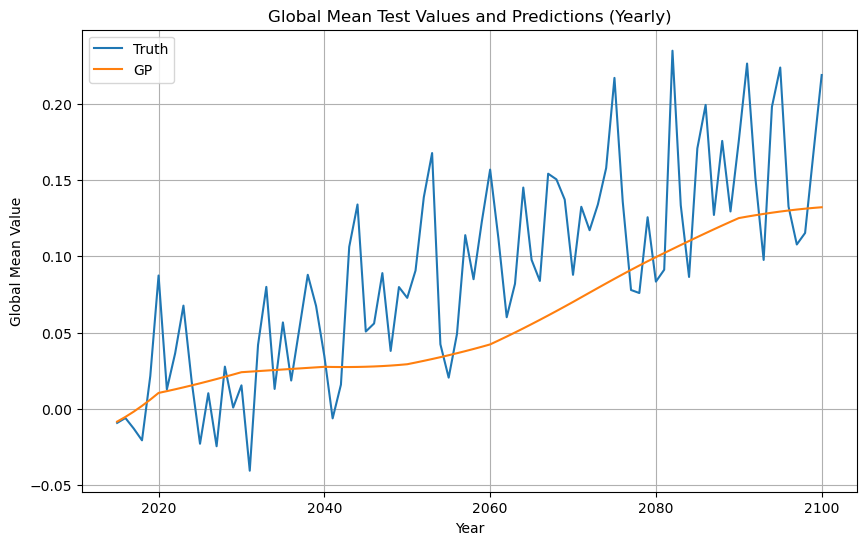

In [47]:
plt.figure(figsize=(10, 6))
global_mean(pr_truth).plot(label="Truth")
global_mean(mean_best).plot(label='GP')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

[Text(0.5, 1.0, 'Difference')]

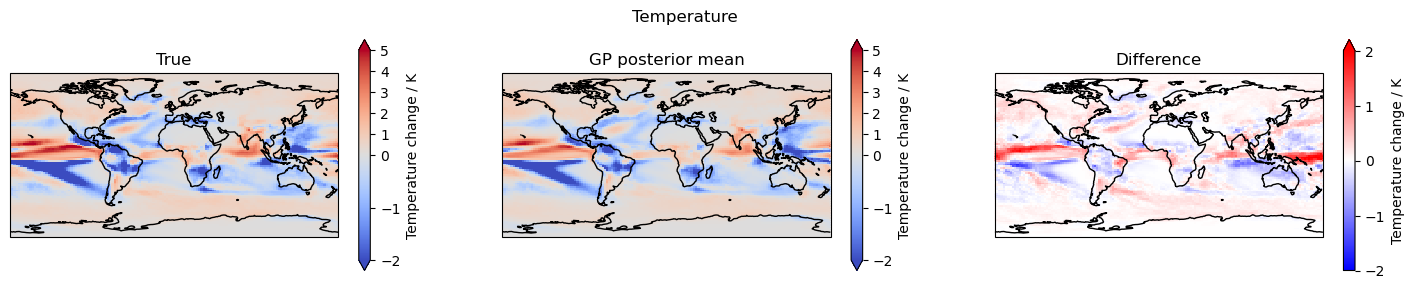

In [48]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
mean_best.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr_truth - mean_best
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [44]:
mean_best.to_netcdf('model/final-gp-best-2-model-mean-pr90.nc')
std_best.to_netcdf('model/final-gp-best-2-model-std-pr90.nc')